### Libraries

Install some libraries

In [32]:
from app_store_scraper import AppStore
import pandas as pd
import re 
import numpy as np
import matplotlib.pyplot as plt

### Ok now get some reviews

This command doesn't work for me but it should for you...

In [2]:
# bunq = AppStore(country="nl", app_name="bunq",)
# bunq.review(how_many=1000)

# # save these reviews in a nice format
# bunq_reviews_df = pd.DataFrame(data = bunq.reviews)
# # write this to file so we don't have to load it every time
# bunq_reviews_df.to_csv('./data/bunq_reviews.csv')

... so I'll just load the data

In [3]:
bunq_reviews_df = pd.read_csv('./data/bunq_reviews.csv', index_col = 0)

Aaaaaand now we can see it's all in a nice table":

In [4]:
# make a version with everything lowercase and no punctuation
def remove_punctuation_and_make_lower(str_in):
    # function to remove punctuation
    str_out = re.sub(r'[^\w\s]', '', str_in) 
    return ' '+str_out.lower()+' '

bunq_reviews_df['review_clean'] = bunq_reviews_df['review'].apply(lambda x: remove_punctuation_and_make_lower(x))

In [5]:
bunq_reviews_df.head(5)

,date,developerResponse,isEdited,rating,review,title,userName,review_clean
0,2018-03-18 21:55:14,"{'id': 2954332, 'body': ""🙂 Thank you for your ...",False,5,"De enige reden dat bunq investeert, in staatso...",Meest ethische bank,whaha,de enige reden dat bunq investeert in staatso...
1,2020-06-18 15:08:26,NaN,False,1,I was a big fan of Bunq until the recent updat...,I was a big fan,IPOQI,i was a big fan of bunq until the recent upda...
2,2020-06-18 14:36:10,NaN,False,1,Dit is de eerste keer in mijn leven dat ik mij...,Wat een waardeloze update,Robert U NL,dit is de eerste keer in mijn leven dat ik mi...
3,2020-06-18 15:07:05,NaN,False,1,With the V3 update Bunq totally messed up! Clu...,V3 totally messed up,R@lfee,with the v3 update bunq totally messed up clu...
4,2020-06-18 14:12:30,NaN,False,1,Grote fan geweest van Bunq. Maar met de laatst...,Verschrikkelijk na update,slammer1024,grote fan geweest van bunq maar met de laatst...


Let's look at a random review just to see what people are saying:

In [6]:
rand_row = np.random.choice(bunq_reviews_df.index)
print('original review:\n')
print(bunq_reviews_df.loc[rand_row]['review'])

print('\ncleaned review:\n')
print(bunq_reviews_df.loc[rand_row]['review_clean'])

original review:

Slechter dan dit kan het niet

cleaned review:

 slechter dan dit kan het niet 


Ok now load in the vocabulary we want to search for

In [7]:
vocab_df = pd.read_csv('./data/corpus.txt', sep = ".", header = None )
vocab_df.columns = ['idx', 'word']

In [8]:
vocab_df['word'] = vocab_df['word'].apply(lambda x: x.replace('\t', '').lower().strip())

In [9]:
word_list = vocab_df.word.values

In [10]:
word_list

array(['completeness', 'compleet', 'bug', 'ux', 'user experience', 'ui',
       'user interface', '2fa', 'factor authentication', 'face id',
       'gezichtsherkenning', 'finger id', 'vingerherkenning',
       'gebruikersvriendelijk', 'user friendliness', 'privacy', 'update',
       'design', 'interface', 'functie', 'widget', 'ideal', 'privacy',
       'veilig', 'security', 'overzicht', 'clear', 'service', 'style',
       'apple pay', 'native', 'crash', 'snelheid', 'speed',
       'functionaliteit', 'notificatie', 'alert', 'dark mode',
       'adaptable', 'aanpasbaar', 'customize', 'inlog', 'log in', 'login',
       'log-in', 'contact', 'technisch', 'technical', 'data',
       'integratie', 'integration', 'helpdesk', 'feedback', 'makkelijk',
       'easy', 'intuitive', 'intuitief', 'pincode', 'authenticatie',
       'authentication', 'sustainable', 'duurzaam', 'environment',
       'toekomst', 'future', 'gamification'], dtype=object)

Ok, now try to find those words in the review

In [11]:
def find_if_word_in_str(str_in, word_list):
    contains_words = []
    for try_word in word_list:
        if str_in.count(' '+try_word+' '):
            contains_words.append(try_word)
    
    return contains_words

def count_word_in_str(str_in, word_list):
    contains_words = 0
    for try_word in word_list:
        if str_in.count(' '+try_word+' '):
            contains_words = contains_words + 1
    
    return contains_words

In [12]:
bunq_reviews_df['n_feature_words'] = bunq_reviews_df['review_clean'].apply(lambda x: count_word_in_str(x, word_list))
bunq_reviews_df['feature_words'] = bunq_reviews_df['review_clean'].apply(lambda x: find_if_word_in_str(x, word_list))

In [13]:
# make a column for each word
for try_word in word_list:
    bunq_reviews_df[try_word] = bunq_reviews_df['review_clean'].apply(lambda x: count_word_in_str(x, [try_word]))

Let's only look at reviews which include the words we're interested in

In [14]:
bunq_feats_df = bunq_reviews_df[bunq_reviews_df['n_feature_words']>0].copy()

Aaaaaand also let's drop any columns we don't care about

In [15]:
bunq_feats_df.drop(columns = ['developerResponse', 'isEdited',  'userName'], inplace = True)

Also drop any columns which count feature words which weren't used

In [16]:
feature_word_counts = pd.DataFrame(bunq_feats_df.drop(columns = ['date','rating','review','title', 'review_clean', 'n_feature_words','feature_words']).sum()).rename(columns = {0:'counts'}).sort_values('counts', ascending = False)

In [17]:
feature_word_counts

,counts
update,253
interface,52
ux,51
service,46
design,45
...,...
vingerherkenning,0
finger id,0
factor authentication,0
2fa,0


We see that "update" is pretty hgih up there. The following feature words weren't used:

In [24]:
words_not_used = feature_word_counts[feature_word_counts.counts == 0].index.values
print('\n'.join(words_not_used))

duurzaam
authenticatie
completeness
log-in
aanpasbaar
adaptable
alert
user friendliness
vingerherkenning
finger id
factor authentication
2fa
speed


so we'll remove those count columns

In [25]:
bunq_feats_df.drop(columns = words_not_used, inplace=True)

Ok, let's dive deeper into a single feature word, here's a list of the words we can explore:

In [29]:
words_used = feature_word_counts[feature_word_counts.counts > 0].index.values
print('Words used (in descending order of popularity):\n')
print('\n'.join(words_used))

Words used (in descending order of popularity):

update
interface
ux
service
design
ui
easy
feedback
makkelijk
intuitive
contact
apple pay
overzicht
compleet
clear
ideal
functie
user interface
user experience
toekomst
gamification
bug
helpdesk
functionaliteit
pincode
future
environment
dark mode
veilig
login
security
log in
integratie
data
snelheid
native
sustainable
privacy
gezichtsherkenning
technical
widget
integration
face id
technisch
style
intuitief
inlog
customize
authentication
notificatie
crash
gebruikersvriendelijk


Let's just look at reviews containg ne of these words, take UX as our example

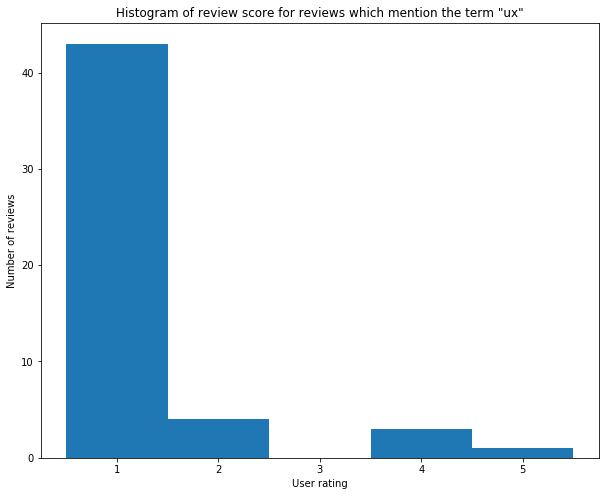

In [50]:
feature_to_lookinto = 'ux' # n.b. everything has to be lowercase
bunq_feats_df_subset = bunq_feats_df[bunq_feats_df[feature_to_lookinto]>0]

fig, ax = plt.subplots(figsize = [10, 8])
ax.hist(bunq_feats_df_subset['rating'], bins= [0.5, 1.5, 2.5, 3.5, 4.5, 5.5])
ax.set_xlabel('User rating')
ax.set_ylabel('Number of reviews')
ax.set_title('Histogram of review score for reviews which mention the term "{}"'.format(feature_to_lookinto))
plt.show()

In [55]:
# pick out one review at random that mentions this
print(bunq_feats_df_subset.sample(1).review.values[0])

All of the feedback and bug reports received during the public beta were promptly ignored and thus made V3 a terrible release. The UX is god-awful, my online cards have all but disappeared, dual pin is disabled for physical cards and everything that used to take 1-2 taps to navigate to is now a nightmare to get to. Oh and the social feed is garbage
